In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

# fit

In [8]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import random
import json
import math
import keras.backend as K
from keras.models import load_model

DATA_SHAPE = 224
val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
val_cluster = np.load('/home/mc16/result/val_cluster_06-14-06:38:40.npy')
test1_cluster = np.load('/home/mc16/result/test1_cluster_06-14-06:41:52.npy')

In [9]:
def get_xmin(mask, thresh):
    mask = np.array(mask)
    sum_mask = np.sum(mask, axis=1)
    for i in range(len(sum_mask)):
        if sum_mask[i] > thresh:
            return i
    return 0

def get_predict_point_per_sample(points, d, x_min):
    line_list = []
    if(len(points)==0):
        return line_list
    
    for line_num in range(points.shape[0]):
        x = points[line_num][:, 0]
        y = points[line_num][:, 1]
        x_range = x.max() - x.min()
        y_range = y.max() - y.min()
        if (x_range < 20 and y_range < 20):
            continue
        z = np.polyfit(x, y, d)
        p = np.poly1d(z)
        temp_x = range(x_min, 223)
        temp_y = p(temp_x)
        temp_x_y = []
        for i in range(temp_x.__len__()):
            if temp_y[i] > 223:
                temp_y[i] = 223
            if temp_y[i] < 0:
                continue
            temp_x_y.append([temp_x[i], int(temp_y[i])])
        line_list.append(temp_x_y)
    return line_list

def lines_to_img(lines, shape):
    pic = np.zeros((shape, shape), np.uint8)
    for line in lines:
        for point in line:
            pic[point[0], point[1]] = 255
    return pic

def cluster_to_img(cluster_points, shape):
    pic = np.zeros((shape, shape), np.uint8)
    num_label = cluster_points.shape[0]
    for i in range(num_label):
        for point in cluster_points[i]:
#             print(point)
            pic[point[0], point[1]] = 50 + i * int((255 - 50) / num_label) 
    return pic

In [10]:
def delete_cluster(points, cluster_list):
    points = np.delete(points, cluster_list, axis=0)
    return points

def get_line_info(points, X_RANGE_LIM = 20, Y_RANGE_LIM = 20):
    ## 得到符合条件的line, line_info
    ## 返回points, line_info_right, line_info_polar
    line_info_right = []
    line_info_polar = []
    delete_cluster_list = []
    for line_num in range(points.shape[0]):
        x = points[line_num][:, 0]
        y = points[line_num][:, 1]
        
        ## 过滤，并删除太小的簇
        x_range = x.max() - x.min()
        y_range = y.max() - y.min()
        if x_range < X_RANGE_LIM and y_range < Y_RANGE_LIM:
            delete_cluster_list.append(line_num)
            continue
    
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        line_info_right.append(z)
        z_j = z.copy()
        z_j[0] = (math.atan(z_j[0]) * 180 / math.pi) - 90
        z_j[1] = z_j[1] * math.sin(z_j[0])
        line_info_polar.append(z_j)
    
    points = delete_cluster(points, delete_cluster_list)
    return points, line_info_right, line_info_polar

## 根据传入的每条线的极坐标参数，角度阈值，距离阈值，将符合条件的簇删掉（todo 合并）
def get_flg_arr(line_info_polar, ANGEL = 20, DIS = 50):
    i = 0
    flg = []
    for i in range(line_info_polar.__len__()):
        flg.append(0)
    
    flg_id = 1
    i = 0
    while i < line_info_polar.__len__():
        if flg[i] == 0:
            flg[i] = flg_id
            flg_id += 1
        else:
            i += 1
            continue
        j = i + 1
        while(j < line_info_polar.__len__()):
            if flg[j] != 0:
                j += 1
                continue
            if abs(line_info_polar[i][0] - line_info_polar[j][0]) < ANGEL and abs(line_info_polar[i][1] - line_info_polar[j][1]) < DIS:
                flg[j] = flg[i]
            j += 1
        i += 1
    return flg

# input struct line -> point
def get_better_line_per_sample(points, x_min, ANGEL=20, DIS=50, X_RANGE_LIM=20, Y_RANGE_LIM=20):
    line_list = []
    if(len(points)==0):
        return line_list
        
    x_min_mean = x_min
    new_points, line_info_right, line_info_polar = get_line_info(points, X_RANGE_LIM, Y_RANGE_LIM)
    line_info = line_info_polar
    flg = get_flg_arr(line_info_polar, ANGEL, DIS)
    
    temp_x = range(x_min_mean, 223)
    temp_x_y = []; line_list = []; flg_id = 1; zs = []
    while flg_id <= np.array(flg).max():
        i = 0
        z = [0, 0]
#         count = 0
        x_max_range = 0
        max_index = 0
        for i in range(flg.__len__()):
            if flg[i] == flg_id:
                cur_x_range = new_points[i][:, 0].max() - new_points[i][:, 0].min()
                if x_max_range == 0:
                    x_max_range = cur_x_range
                    max_index = i
                else:
                    if cur_x_range > x_max_range:
                        max_index = i
                    else:
                        pass
                    
#                 count += 1
        z[0] = line_info_right[i][0]
        z[1] = line_info_right[i][1]
#         z[0] = z[0] / count
#         z[1] = z[1] / count
        zs.append(z)
        flg_id += 1
        
    for line_num in range(zs.__len__()):
        line_p = np.poly1d(zs[line_num])
        temp_y = line_p(temp_x)
        j = 0
        for i in range(temp_x.__len__()):
            if temp_y[i] < 0 or temp_y[i] > 223:
                continue
            temp_x_y.append([temp_x[i], int(temp_y[i])])
            
        line_list.append(temp_x_y)
        
    ## 限定返回值的范围
    return line_list

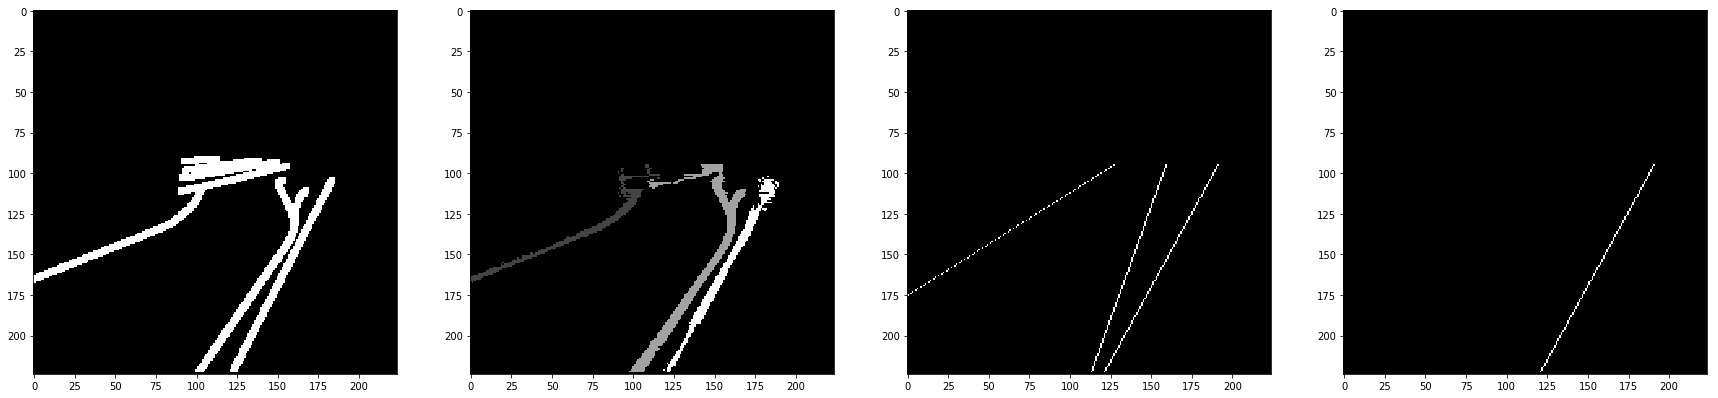

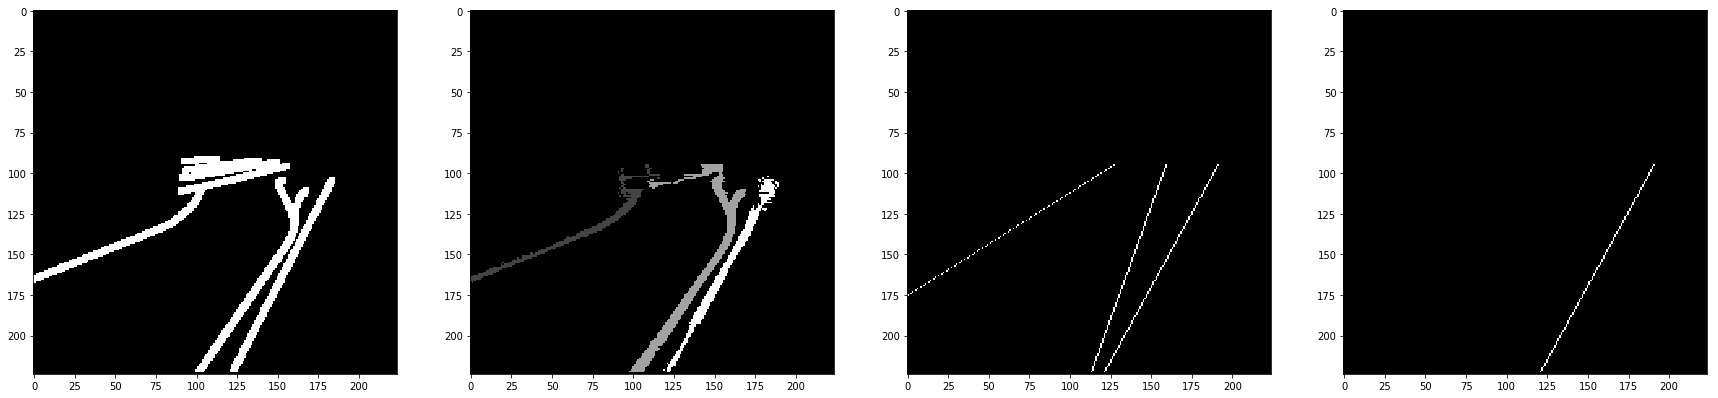

In [12]:
MIN_THRESH = 200

# test_index = random.randint(0, len(val_cluster))
test_index = 240
test_label = val_labels[test_index,:,:,1]
test_cluster = val_cluster[test_index]
cluster_img = cluster_to_img(test_cluster, DATA_SHAPE)
xmin = get_xmin(cluster_img, MIN_THRESH)
all_lines = get_predict_point_per_sample(test_cluster, 1, xmin)
all_img = lines_to_img(all_lines, DATA_SHAPE)
better_lines = get_better_line_per_sample(test_cluster, xmin, ANGEL=15, DIS=50)
better_img = lines_to_img(better_lines, DATA_SHAPE)

fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(test_label, cmap='gray')
axs[1].imshow(cluster_img, cmap='gray')
axs[2].imshow(all_img, cmap='gray')
axs[3].imshow(better_img, cmap='gray')
# print(test_index, len(test_lines))
plt.show()

In [44]:
def get_fit_lines(clusters_list, d):
    lines_list = []
    for clusters in tqdm(clusters_list):
        cluster_img = cluster_to_img(clusters, DATA_SHAPE)
        xmin = get_xmin(cluster_img, MIN_THRESH)
        lines = get_predict_point_per_sample(clusters, d, xmin)
        lines_list.append(lines)
    return lines_list
    
val_fit = get_fit_lines(val_cluster, 1)

100%|██████████| 2015/2015 [00:04<00:00, 411.74it/s]


# Save json

In [158]:
def np2json(arlines):
    json_lines = []
    for arline in arlines:
        json_line = []
        for point in arline:
            json_line.append({"x":int(point[1]), "y":int(point[0])})
        json_lines.append(json_line)
    return {"Lanes": json_lines}

def save_jsons(lines_list, list_path, json_path):
    test_md5_paths = open(list_path, 'r').readlines()
    for i, lines in tqdm(enumerate(lines_list)):
        md5 = test_md5_paths[i].split('.')[0]
        lines_json = np2json(lines)
        lines_str = json.dumps(lines_json)
        file = open(json_path + '%s.json'%md5,'w')
        file.write(lines_str)
        file.close()
        
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_json_path = '/home/mc16/result_json/val_results/'
save_jsons(val_fit, val_list_path, val_json_path)

2015it [00:00, 2071.50it/s]


In [159]:
!python /home/mc16/evalue.py

2015it [00:33, 59.75it/s]
{'f1': 0.4273001625009673, 'code': 0, 'precision': 0.5044765211035995, 'recall': 0.3706040268456376}


In [67]:
test1_fit = get_fit_lines(test1_cluster, 1)
test1_list_path = '/home/mc16/test1_list.txt'
test1_json_path = '/home/mc16/result_json/results/'
save_jsons(test1_fit, test1_list_path, test1_json_path)

100%|██████████| 2034/2034 [00:08<00:00, 240.00it/s]
2034it [00:01, 1378.94it/s]
